In [17]:
!pip install datasets transformers[sentencepiece] sacrebleu tensorflow -q

In [18]:
!pip install matplotlib scikit-learn nltk numpy pandas -q
import matplotlib.pyplot as plt
import numpy as np

In [19]:
import os
import sys
import transformers
import tensorflow as tf
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import AdamWeightDecay
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

In [20]:
raw_datasets = load_dataset("cfilt/iitb-english-hindi")
raw_datasets['train'] = raw_datasets['train'].select(range(1000))

## Tokenization

In [21]:
model_checkpoint = "Helsinki-NLP/opus-mt-en-hi"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [22]:
max_input_length = 128
max_target_length = 128

source_lang = "en"
target_lang = "hi"


def preprocess_function(examples):
    inputs = [ex[source_lang] for ex in examples["translation"]]
    targets = [ex[target_lang] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [23]:
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

## Model Initialization

In [24]:
model_checkpoint = "Helsinki-NLP/opus-mt-en-hi"
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at Helsinki-NLP/opus-mt-en-hi.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


In [25]:
batch_size = 16
learning_rate = 2e-5
weight_decay = 0.01
num_train_epochs = 1

In [26]:
optimizer = AdamWeightDecay(learning_rate=learning_rate, weight_decay_rate=weight_decay)
model.compile(optimizer = optimizer)

## Data Preperation

In [27]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")
generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf", pad_to_multiple_of=128)

In [28]:
train_dataset = model.prepare_tf_dataset(
    tokenized_datasets["train"],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator,
)

In [29]:
validation_dataset = model.prepare_tf_dataset(
    tokenized_datasets["validation"],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
)

In [30]:
generation_dataset = model.prepare_tf_dataset(
    tokenized_datasets["test"],
    batch_size=8,
    shuffle=False,
    collate_fn=generation_data_collator,
)

## Model Training

In [31]:
# model.fit(train_dataset, validation_data=validation_dataset, epochs=1)
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=5, verbose = 1)

model.save_pretrained("tf_model/")

Epoch 1/5
62/62 [==============================] - 56s 355ms/step - loss: 0.7831 - val_loss: 4.3805
Epoch 2/5
62/62 [==============================] - 17s 275ms/step - loss: 0.3216 - val_loss: 4.4029
Epoch 3/5
62/62 [==============================] - 17s 268ms/step - loss: 0.1901 - val_loss: 4.4212
Epoch 4/5
62/62 [==============================] - 15s 244ms/step - loss: 0.1336 - val_loss: 4.4284
Epoch 5/5
62/62 [==============================] - 15s 248ms/step - loss: 0.1051 - val_loss: 4.4472


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:397: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[61949]]}
  warnings.warn(


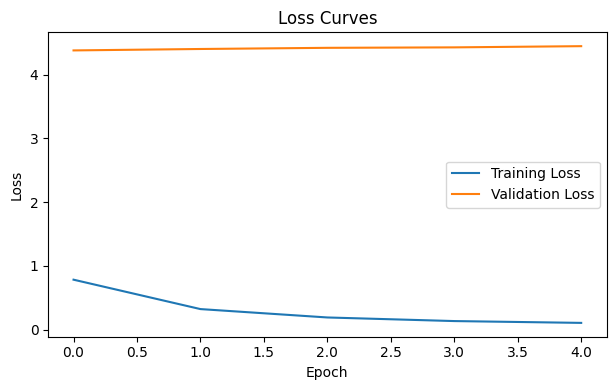

In [32]:

# Visualize training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

if 'accuracy' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
plt.tight_layout()
plt.savefig('training_curves_tf.png')
plt.show()

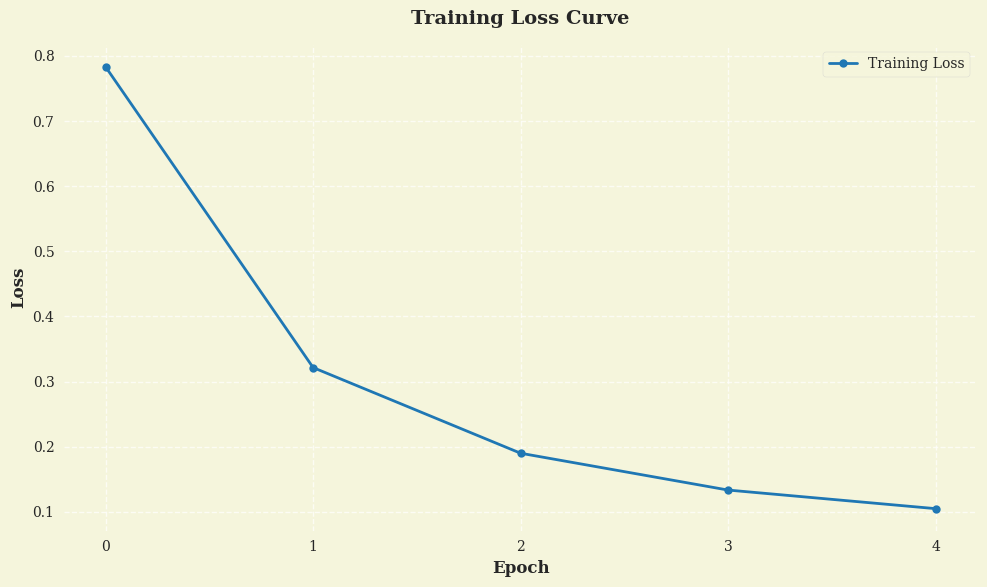

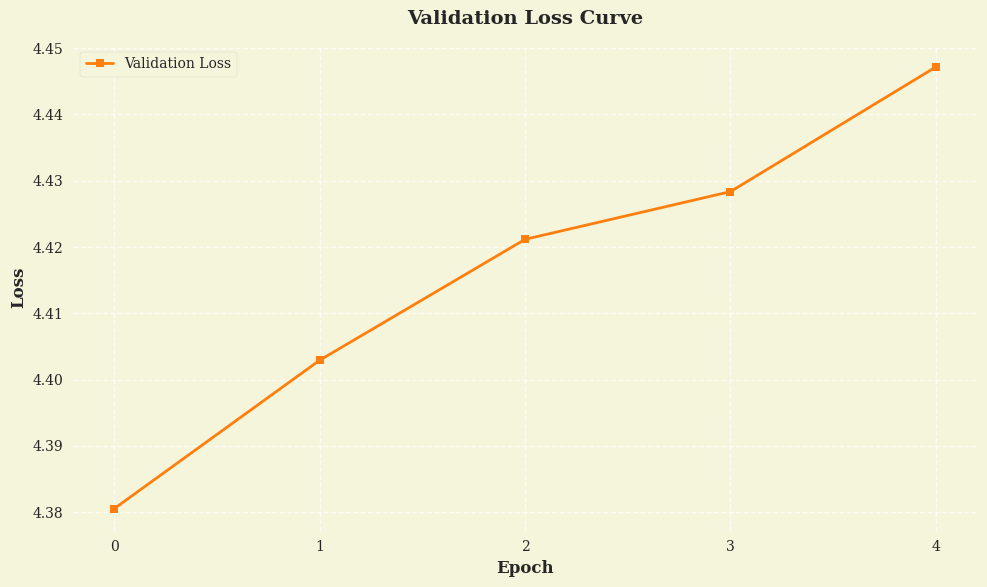

In [33]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set professional plot style
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'DejaVu Serif'
mpl.rcParams['font.size'] = 11
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
background_color = '#f5f5dc'  # beige

# Plot Training Loss - Separate figure
plt.figure(figsize=(10, 6))
ax = plt.gca()
plt.gcf().patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

plt.plot(history.history['loss'], label='Training Loss',
         color='#1f77b4', linewidth=2, marker='o', markersize=6)
plt.title('Training Loss Curve', weight='bold', pad=15)
plt.xlabel('Epoch', weight='bold')
plt.ylabel('Loss', weight='bold')
plt.legend(frameon=True, facecolor=background_color)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(len(history.history['loss'])))  # Ensure ticks for each epoch
plt.tight_layout()
plt.savefig('training_loss_tf.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot Validation Loss - Separate figure
plt.figure(figsize=(10, 6))
ax = plt.gca()
plt.gcf().patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

plt.plot(history.history['val_loss'], label='Validation Loss',
         color='#ff7f0e', linewidth=2, marker='s', markersize=6)
plt.title('Validation Loss Curve', weight='bold', pad=15)
plt.xlabel('Epoch', weight='bold')
plt.ylabel('Loss', weight='bold')
plt.legend(frameon=True, facecolor=background_color)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(len(history.history['val_loss'])))  # Ensure ticks for each epoch
plt.tight_layout()
plt.savefig('validation_loss_tf.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot Accuracy curves if they exist
if 'accuracy' in history.history:
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    plt.gcf().patch.set_facecolor(background_color)
    ax.set_facecolor(background_color)

    plt.plot(history.history['accuracy'], label='Training Accuracy',
             color='#2ca02c', linewidth=2, marker='o', markersize=6)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy',
             color='#d62728', linewidth=2, marker='s', markersize=6)
    plt.title('Accuracy Curves', weight='bold', pad=15)
    plt.xlabel('Epoch', weight='bold')
    plt.ylabel('Accuracy', weight='bold')
    plt.legend(frameon=True, facecolor=background_color)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(len(history.history['accuracy'])))  # Ensure ticks for each epoch
    plt.tight_layout()
    plt.savefig('accuracy_curves_tf.png', dpi=300, bbox_inches='tight')
    plt.show()

## Evaluate

In [34]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained("tf_model/")

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


In [35]:
raw_datasets['validation']

Dataset({
    features: ['translation'],
    num_rows: 520
})

In [36]:
pred = []
for i in range(250):
  input_text  = raw_datasets['test'][i]['translation']['en']
  # print(input_text)
  tokenized = tokenizer([input_text], return_tensors='np')
  out = model.generate(**tokenized, max_length=128)
  with tokenizer.as_target_tokenizer():
      # print(tokenizer.decode(out[0], skip_special_tokens=True))
      pred.append(tokenizer.decode(out[0], skip_special_tokens=True))

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [37]:
!pip install rouge_score sacrebleu evaluate -q
!pip install --upgrade datasets -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.4 MB/s eta 0:00:00


In [38]:
from evaluate import load

test_translations = [ex['translation']['hi'] for ex in raw_datasets['test']]

test_translations = test_translations[:len(pred)]
# Calculate BLEU score
bleu = load("sacrebleu")
bleu_score = bleu.compute(predictions=pred, references=[[ref] for ref in test_translations])
print("BLEU Score:", bleu_score)

# Calculate ROUGE score
rouge = load("rouge")
rouge_score = rouge.compute(predictions=pred, references=test_translations)
print("ROUGE Score:", rouge_score)

# Calculate METEOR score
meteor = load("meteor")
meteor_score = meteor.compute(predictions=pred, references=test_translations)
print("METEOR Score:", meteor_score)


BLEU Score: {'score': 10.585936830757449, 'counts': [2105, 824, 350, 148], 'totals': [5325, 5075, 4825, 4575], 'precisions': [39.53051643192488, 16.236453201970445, 7.253886010362694, 3.2349726775956285], 'bp': 0.9555711930511664, 'sys_len': 5325, 'ref_len': 5567}


ROUGE Score: {'rouge1': np.float64(0.09546666666666667), 'rouge2': np.float64(0.019666666666666666), 'rougeL': np.float64(0.09461904761904762), 'rougeLsum': np.float64(0.09454285714285714)}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


METEOR Score: {'meteor': np.float64(0.30358259557771977)}


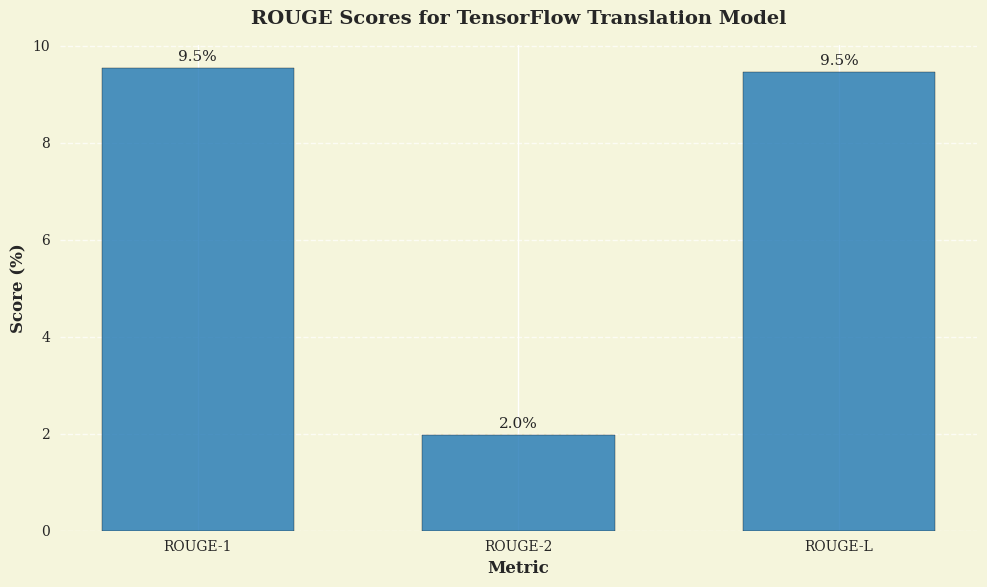

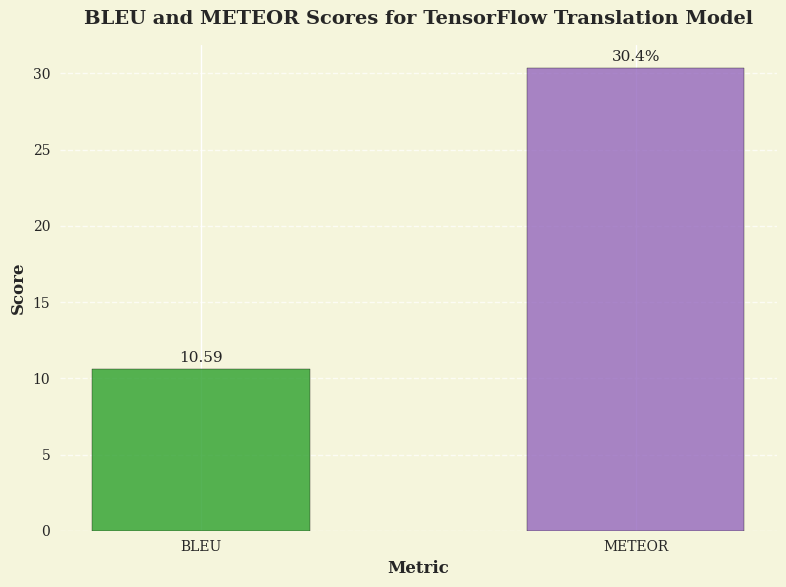


Example 1:
Source (EN): A black box in your car?
Reference (HI): आपकी कार में ब्लैक बॉक्स?
Hypothesis (HI): अपनी कार में एक ब्लैक बॉक्स?

Example 2:
Source (EN): As America's road planners struggle to find the cash to mend a crumbling highway system, many are beginning to see a solution in a little black box that fits neatly by the dashboard of your car.
Reference (HI): जबकि अमेरिका के सड़क योजनाकार, ध्वस्त होते हुए हाईवे सिस्टम को सुधारने के लिए धन की कमी से जूझ रहे हैं, वहीं बहुत-से लोग इसका समाधान छोटे से ब्लैक बॉक्स में देख रहे हैं, जो आपकी कार के डैशबोर्ड पर सफ़ाई से फिट हो जाता है।
Hypothesis (HI): के रूप में अमेरिका के सड़क योजनार एक बंद सड़क प्रणाली को सुधारने के लिए नकदी को खोजने के लिए संघर्ष, कई शुरू कर रहे हैं एक छोटे से काले बॉक्स में एक समाधान देखने के लिए।

Example 3:
Source (EN): The devices, which track every mile a motorist drives and transmit that information to bureaucrats, are at the center of a controversial attempt in Washington and state planning offices to ove

In [39]:
# Visualize TensorFlow model evaluation metrics with professional plots
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set professional plot style
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'DejaVu Serif'
mpl.rcParams['font.size'] = 11
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
background_color = '#f5f5dc'  # beige

# Store metrics for later comparison
metrics = {
    'BLEU': bleu_score['score'],
    'rouge1': rouge_score['rouge1'],
    'rouge2': rouge_score['rouge2'],
    'rougeL': rouge_score['rougeL'],
    'METEOR': meteor_score['meteor'] * 100
}

# ROUGE Scores for TensorFlow model
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

rouge_metrics = ['rouge1', 'rouge2', 'rougeL']
rouge_names = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
rouge_values = [metrics[m] * 100 for m in rouge_metrics]

bars = ax.bar(rouge_names, rouge_values, color='#1f77b4', edgecolor='black', alpha=0.8, width=0.6)

ax.set_xlabel('Metric', weight='bold')
ax.set_ylabel('Score (%)', weight='bold')
ax.set_title('ROUGE Scores for TensorFlow Translation Model', weight='bold', pad=15)
ax.grid(True, linestyle='--', alpha=0.7, axis='y')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.savefig('tf_rouge_scores.png', dpi=300, bbox_inches='tight')
plt.show()

# BLEU and METEOR scores for TensorFlow model
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

other_metrics = ['BLEU', 'METEOR']
other_values = [metrics['BLEU'], metrics['METEOR']]

bars = ax.bar(other_metrics, other_values, color=['#2ca02c', '#9467bd'],
              edgecolor='black', alpha=0.8, width=0.5)

ax.set_xlabel('Metric', weight='bold')
ax.set_ylabel('Score', weight='bold')
ax.set_title('BLEU and METEOR Scores for TensorFlow Translation Model', weight='bold', pad=15)
ax.grid(True, linestyle='--', alpha=0.7, axis='y')

# Add value labels on top of bars with appropriate formatting
for i, bar in enumerate(bars):
    height = bar.get_height()
    if other_metrics[i] == 'METEOR':
        label = f'{height:.1f}%'
    else:
        label = f'{height:.2f}'
    ax.annotate(label,
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.savefig('tf_bleu_meteor_scores.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualize sample translations (optional but helpful)
sample_size = min(5, len(pred))
samples = [(raw_datasets['test'][i]['translation']['en'],
            raw_datasets['test'][i]['translation']['hi'],
            pred[i]) for i in range(sample_size)]

for i, (src, ref, hyp) in enumerate(samples):
    print(f"\nExample {i+1}:")
    print(f"Source (EN): {src}")
    print(f"Reference (HI): {ref}")
    print(f"Hypothesis (HI): {hyp}")

##PART2

In [40]:
!pip install datasets rouge_score sacrebleu tensorflow evaluate sacremoses -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 43.8 MB/s eta 0:00:00


In [41]:
import torch
import re
import unicodedata
from datasets import load_dataset
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from sacrebleu import corpus_bleu
from rouge_score import rouge_scorer
import nltk
from nltk.translate.meteor_score import meteor_score
from transformers import AutoTokenizer
import pandas as pd
from evaluate import load
from tqdm import tqdm
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import AdamWeightDecay
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

In [42]:
raw_datasets = load_dataset("cfilt/iitb-english-hindi")

In [43]:
# # Load model and tokenizer
# model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50")
# tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50", src_lang="en_XX", tgt_lang="hi_IN")

In [44]:
model_checkpoint = "Helsinki-NLP/opus-mt-en-hi"
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at Helsinki-NLP/opus-mt-en-hi.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


In [45]:
def normalize_text(text):
        text = text.lower()
        text = unicodedata.normalize('NFKC', text)

        # Replace multiple spaces with single space and leading/tailing whitespace
        text = re.sub(r'\s+', ' ', text)
        text = text.strip()

        # Add spaces around punctuation marks
        text = re.sub(r'([.,!?()])', r' \1 ', text)
        # Cleanup any double spaces created
        text = re.sub(r'\s+', ' ', text).strip()

        return text

In [46]:
def normalize_texts(texts):
    return [normalize_text(text) for text in texts]

In [47]:
# fixing the warning issue
def detokenize_text(text):
    # Fix spaces before punctuation
    text = re.sub(r'\s+([.,!?:;)])', r'\1', text)

    # Fix spaces after opening parentheses
    text = re.sub(r'(\()\s+', r'\1', text)

    # Fix tokenized periods at end of line
    text = re.sub(r'\s+\.\s*$', '.', text)

    # Fix multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [48]:
def detokenize_texts(texts):
    return [detokenize_text(text) for text in texts]

In [49]:
def translate(texts, batch_size=16):
    normalized_texts = normalize_texts(texts)
    translations = []

    for i in range(0, len(normalized_texts), batch_size):
        if i % 48 == 0:
            print(f"Processing batch {i // batch_size + 1}/{len(normalized_texts) // batch_size + 1}")
        batch_texts = normalized_texts[i:i+batch_size]

        # Tokenize
        # inputs = tokenizer(batch_texts, padding=True, return_tensors="pt")
        inputs = tokenizer(batch_texts, padding=True, return_tensors="tf")
        input_ids = inputs.input_ids
        attention_mask = inputs.attention_mask

        # Generate translation
        with torch.no_grad():
            translated_ids = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                num_beams=5,
                early_stopping=True,
            )

        # Decode translations
        batch_translations = tokenizer.batch_decode(translated_ids, skip_special_tokens=True)
        translations.extend(batch_translations)

    # Apply detokenization to fix warnings
    detokenized_translations = detokenize_texts(translations)

    return detokenized_translations

In [50]:
raw_datasets["train"]

Dataset({
    features: ['translation'],
    num_rows: 1659083
})

In [51]:
test_data = raw_datasets["test"].select(range(250))

english_texts = [item["en"] for item in test_data['translation']]
reference_hindi_texts = [item["hi"] for item in test_data['translation']]

reference_hindi_texts = detokenize_texts(reference_hindi_texts)

# Translate English texts to Hindi
print(f"Translating {len(english_texts)} texts...")
translated_hindi_texts = translate(english_texts)

Translating 250 texts...
Processing batch 1/16
Processing batch 4/16
Processing batch 7/16
Processing batch 10/16
Processing batch 13/16
Processing batch 16/16


In [52]:
# Calculate BLEU score with evaluate
bleu = load("sacrebleu")
bleu_scores2 = bleu.compute(predictions=translated_hindi_texts, references=[[ref] for ref in reference_hindi_texts])
print(f"BLEU Score: {bleu_scores2}")

# Calculate ROUGE score with evaluate
rouge = load("rouge")
rouge_scores2 = rouge.compute(predictions=translated_hindi_texts, references=reference_hindi_texts)
print(f"ROUGE Score: {rouge_scores2}")

# Calculate METEOR score with evaluate
meteor = load("meteor")
meteor_scores2 = meteor.compute(predictions=translated_hindi_texts, references=reference_hindi_texts)
print(f"METEOR Score: {meteor_scores2}")

BLEU Score: {'score': 9.210059685540037, 'counts': [1988, 749, 300, 115], 'totals': [5199, 4949, 4699, 4449], 'precisions': [38.238122715906904, 15.134370579915135, 6.384337092998511, 2.584850528208586], 'bp': 0.9316641876974956, 'sys_len': 5199, 'ref_len': 5567}
ROUGE Score: {'rouge1': np.float64(0.07759999999999999), 'rouge2': np.float64(0.009333333333333332), 'rougeL': np.float64(0.0739936507936508), 'rougeLsum': np.float64(0.07375238095238094)}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR Score: {'meteor': np.float64(0.28903274434179604)}


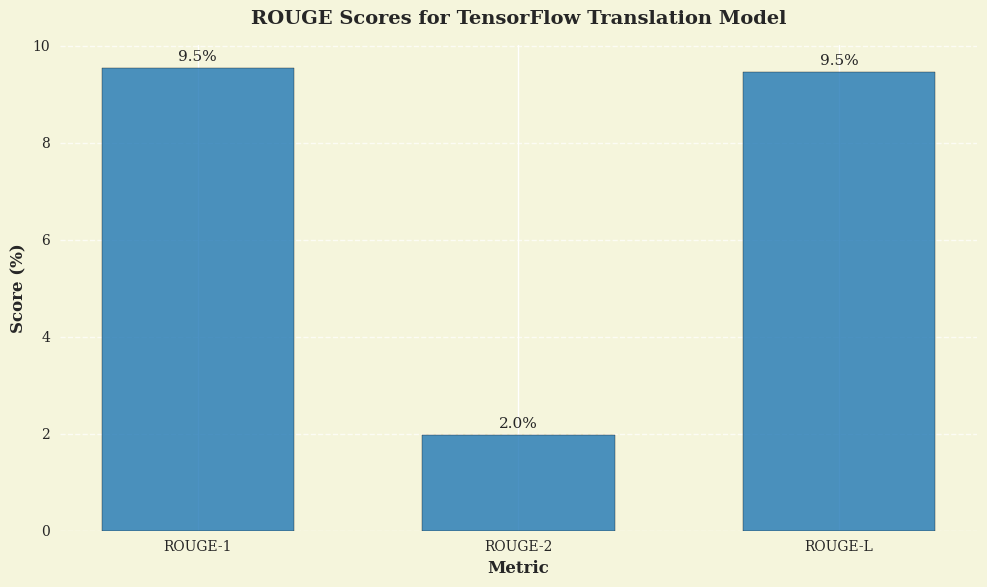

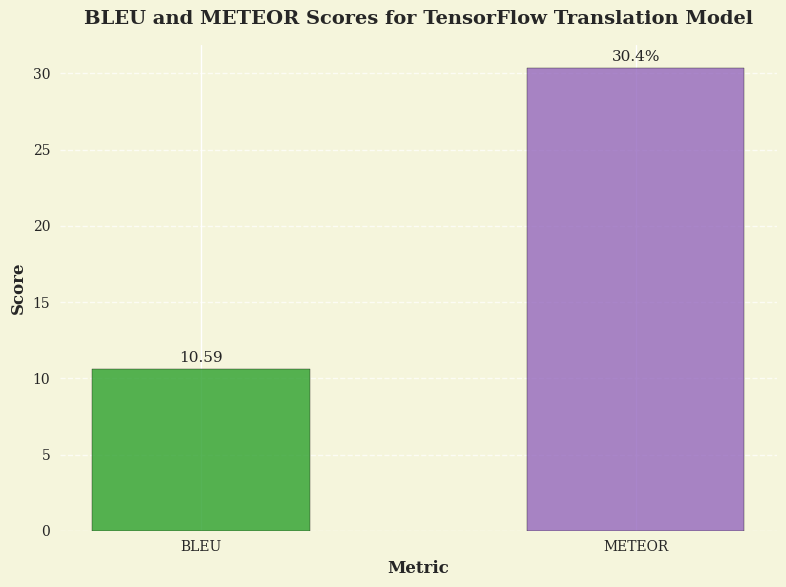


Example 1:
Source (EN): A black box in your car?
Reference (HI): आपकी कार में ब्लैक बॉक्स?
Hypothesis (HI): अपनी कार में एक ब्लैक बॉक्स?

Example 2:
Source (EN): As America's road planners struggle to find the cash to mend a crumbling highway system, many are beginning to see a solution in a little black box that fits neatly by the dashboard of your car.
Reference (HI): जबकि अमेरिका के सड़क योजनाकार, ध्वस्त होते हुए हाईवे सिस्टम को सुधारने के लिए धन की कमी से जूझ रहे हैं, वहीं बहुत-से लोग इसका समाधान छोटे से ब्लैक बॉक्स में देख रहे हैं, जो आपकी कार के डैशबोर्ड पर सफ़ाई से फिट हो जाता है।
Hypothesis (HI): के रूप में अमेरिका के सड़क योजनार एक बंद सड़क प्रणाली को सुधारने के लिए नकदी को खोजने के लिए संघर्ष, कई शुरू कर रहे हैं एक छोटे से काले बॉक्स में एक समाधान देखने के लिए।

Example 3:
Source (EN): The devices, which track every mile a motorist drives and transmit that information to bureaucrats, are at the center of a controversial attempt in Washington and state planning offices to ove

In [53]:
# Visualize TensorFlow model evaluation metrics with professional plots
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set professional plot style
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'DejaVu Serif'
mpl.rcParams['font.size'] = 11
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
background_color = '#f5f5dc'  # beige

# Store metrics for later comparison
metrics2 = {
    'BLEU': bleu_scores2['score'],
    'rouge1': rouge_scores2['rouge1'],
    'rouge2': rouge_scores2['rouge2'],
    'rougeL': rouge_scores2['rougeL'],
    'METEOR': meteor_scores2['meteor'] * 100
}

# ROUGE Scores for TensorFlow model
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

rouge_metrics = ['rouge1', 'rouge2', 'rougeL']
rouge_names = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
rouge_values = [metrics[m] * 100 for m in rouge_metrics]

bars = ax.bar(rouge_names, rouge_values, color='#1f77b4', edgecolor='black', alpha=0.8, width=0.6)

ax.set_xlabel('Metric', weight='bold')
ax.set_ylabel('Score (%)', weight='bold')
ax.set_title('ROUGE Scores for TensorFlow Translation Model', weight='bold', pad=15)
ax.grid(True, linestyle='--', alpha=0.7, axis='y')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.savefig('tf_rouge_scores.png', dpi=300, bbox_inches='tight')
plt.show()

# BLEU and METEOR scores for TensorFlow model
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

other_metrics = ['BLEU', 'METEOR']
other_values = [metrics['BLEU'], metrics['METEOR']]

bars = ax.bar(other_metrics, other_values, color=['#2ca02c', '#9467bd'],
              edgecolor='black', alpha=0.8, width=0.5)

ax.set_xlabel('Metric', weight='bold')
ax.set_ylabel('Score', weight='bold')
ax.set_title('BLEU and METEOR Scores for TensorFlow Translation Model', weight='bold', pad=15)
ax.grid(True, linestyle='--', alpha=0.7, axis='y')

# Add value labels on top of bars with appropriate formatting
for i, bar in enumerate(bars):
    height = bar.get_height()
    if other_metrics[i] == 'METEOR':
        label = f'{height:.1f}%'
    else:
        label = f'{height:.2f}'
    ax.annotate(label,
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.savefig('tf_bleu_meteor_scores.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualize sample translations (optional but helpful)
sample_size = min(5, len(pred))
samples = [(raw_datasets['test'][i]['translation']['en'],
            raw_datasets['test'][i]['translation']['hi'],
            pred[i]) for i in range(sample_size)]

for i, (src, ref, hyp) in enumerate(samples):
    print(f"\nExample {i+1}:")
    print(f"Source (EN): {src}")
    print(f"Reference (HI): {ref}")
    print(f"Hypothesis (HI): {hyp}")

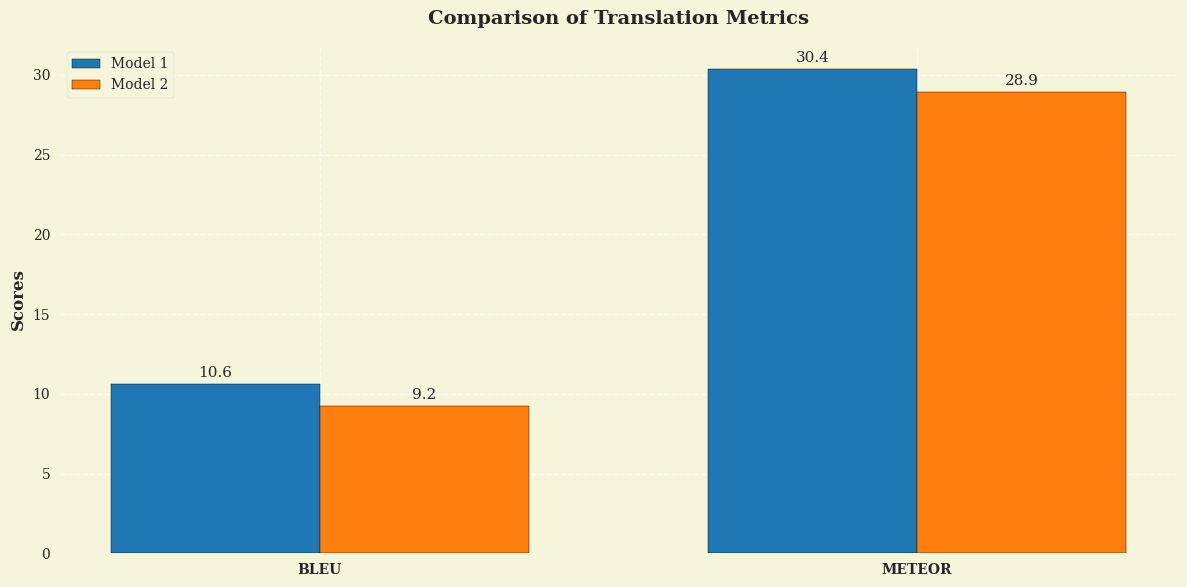

In [54]:
# prompt: Write code to use the dictionaries metrics and metrics2 above and plot a comparison histogram. Make the plot professional with beige background, grid and other things as i need to put it on a report. Ignore the rouge scores and plot

import matplotlib.pyplot as plt

# Set professional plot style
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'DejaVu Serif'
mpl.rcParams['font.size'] = 11
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
background_color = '#f5f5dc'  # beige

# Prepare data for plotting
metric_names = ['BLEU', 'METEOR']
metric_values1 = [metrics['BLEU'],metrics['METEOR']]
metric_values2 = [metrics2['BLEU'], metrics2['METEOR']]

x = range(len(metric_names))
width = 0.35

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

rects1 = ax.bar(x, metric_values1, width, label='Model 1', color='#1f77b4', edgecolor='black')
rects2 = ax.bar([i + width for i in x], metric_values2, width, label='Model 2', color='#ff7f0e', edgecolor='black')

ax.set_ylabel('Scores', weight='bold')
ax.set_title('Comparison of Translation Metrics', weight='bold', pad=15)
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(metric_names, weight='bold')
ax.legend(frameon=True, facecolor=background_color)
ax.grid(True, linestyle='--', alpha=0.7)

# Add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


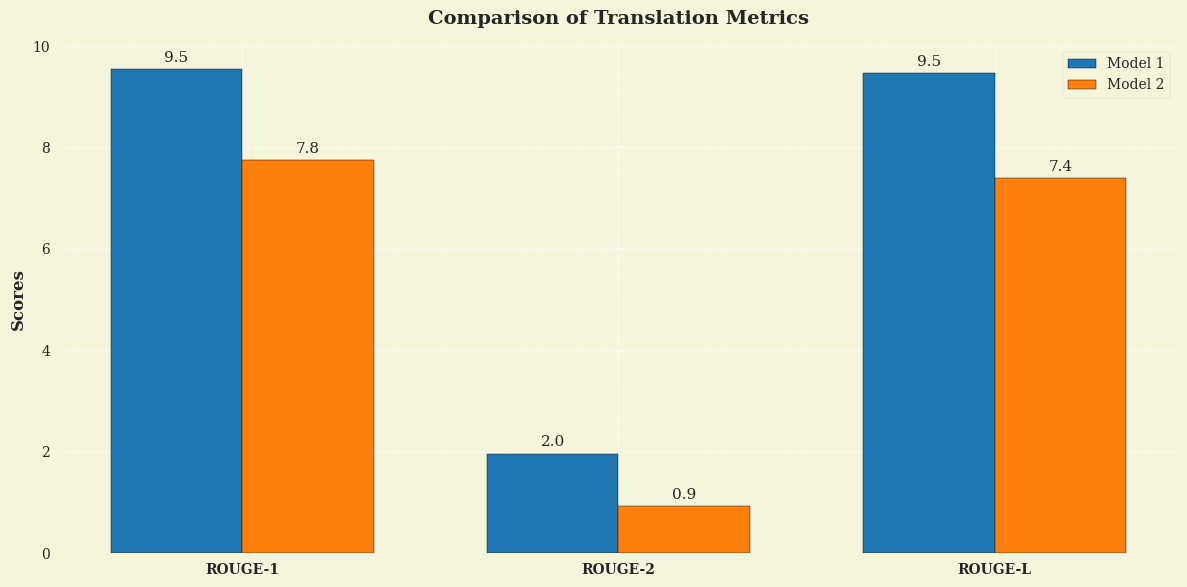

In [55]:
import matplotlib.pyplot as plt

# Set professional plot style
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'DejaVu Serif'
mpl.rcParams['font.size'] = 11
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
background_color = '#f5f5dc'  # beige

# Prepare data for plotting
metric_names = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
metric_values1 = [metrics['rouge1']*100, metrics['rouge2']*100, metrics['rougeL']*100]
metric_values2 = [ metrics2['rouge1']*100, metrics2['rouge2']*100, metrics2['rougeL']*100]

x = range(len(metric_names))
width = 0.35

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

rects1 = ax.bar(x, metric_values1, width, label='Model 1', color='#1f77b4', edgecolor='black')
rects2 = ax.bar([i + width for i in x], metric_values2, width, label='Model 2', color='#ff7f0e', edgecolor='black')

ax.set_ylabel('Scores', weight='bold')
ax.set_title('Comparison of Translation Metrics', weight='bold', pad=15)
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(metric_names, weight='bold')
ax.legend(frameon=True, facecolor=background_color)
ax.grid(True, linestyle='--', alpha=0.7)

# Add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


## Low resource inference

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Analyzing translation complexity vs. quality...


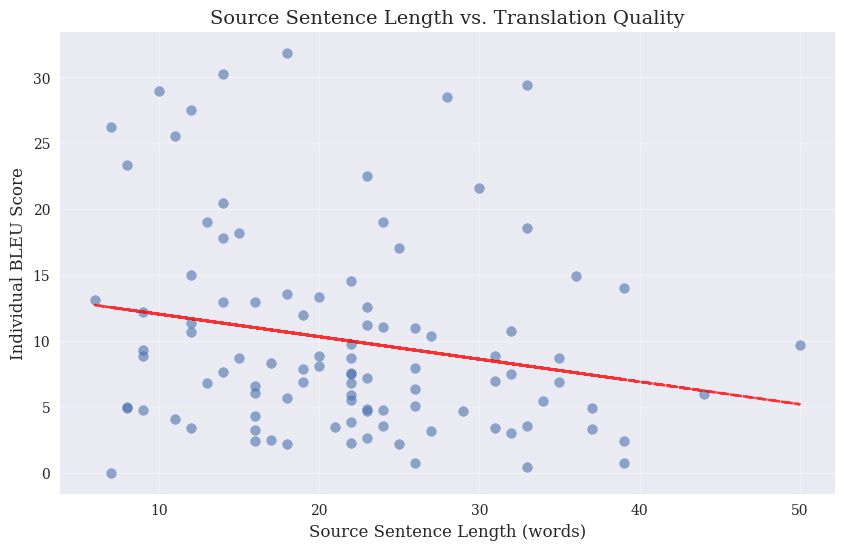

Correlation between sentence length and BLEU score: -0.2077


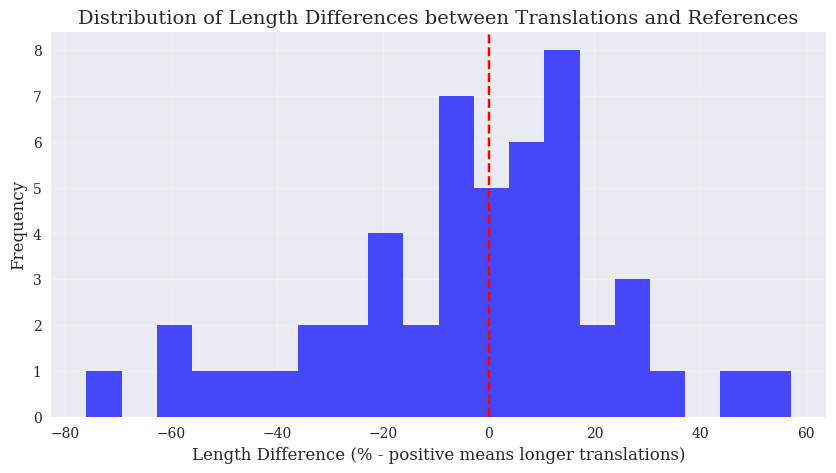

Mean length difference: -3.62% (±27.09%)


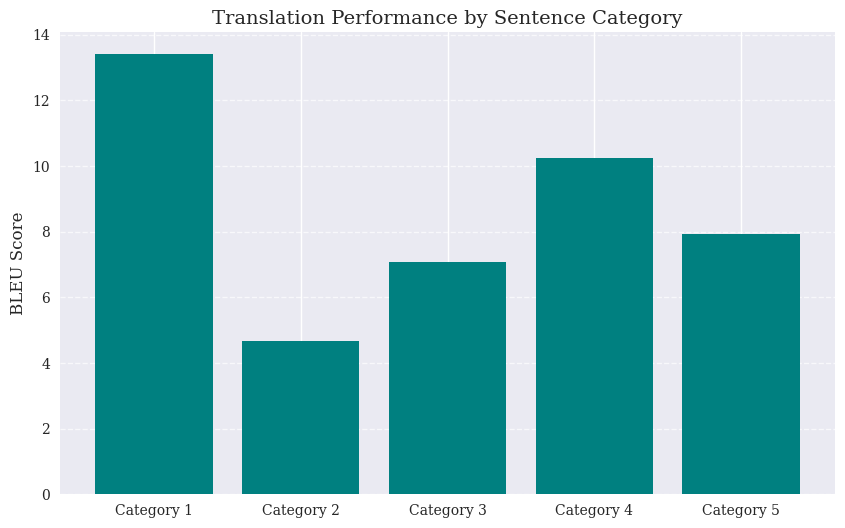

Translation performance by content category:
Category 1: BLEU 13.40
Category 2: BLEU 4.67
Category 3: BLEU 7.07
Category 4: BLEU 10.26
Category 5: BLEU 7.91


In [56]:
# Analysis of low-resource translation challenges
import numpy as np
from collections import Counter
import re

# Import nltk word tokenizer for analysis
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Function to analyze sentence complexity and its effect on translation quality
def analyze_complexity_vs_quality(sources, references, translations, sample_size=100):
    # Use a smaller sample for analysis
    sample_indices = np.random.choice(len(sources), min(sample_size, len(sources)), replace=False)

    source_lengths = []
    bleu_scores = []

    for idx in sample_indices:
        src = sources[idx]
        ref = references[idx]
        trans = translations[idx]

        # Calculate complexity metrics
        src_len = len(nltk.word_tokenize(src))
        source_lengths.append(src_len)

        # Calculate individual BLEU score
        individual_bleu = bleu.compute(predictions=[trans], references=[[ref]])['score']
        bleu_scores.append(individual_bleu)

    # Create plot
    plt.figure(figsize=(10, 6))
    plt.scatter(source_lengths, bleu_scores, alpha=0.6)
    plt.title('Source Sentence Length vs. Translation Quality')
    plt.xlabel('Source Sentence Length (words)')
    plt.ylabel('Individual BLEU Score')

    # Add trend line
    z = np.polyfit(source_lengths, bleu_scores, 1)
    p = np.poly1d(z)
    plt.plot(source_lengths, p(source_lengths), "r--", alpha=0.8)

    plt.grid(True, alpha=0.3)
    plt.savefig('complexity_vs_quality.png')
    plt.show()

    # Return correlation coefficient
    return np.corrcoef(source_lengths, bleu_scores)[0, 1]

# Analyze low-resource challenges using MBart data
print("Analyzing translation complexity vs. quality...")
correlation = analyze_complexity_vs_quality(english_texts, reference_hindi_texts, translated_hindi_texts)
print(f"Correlation between sentence length and BLEU score: {correlation:.4f}")

# Analyze error patterns
def analyze_error_patterns(translations, references, sample_size=50):
    # Use a smaller sample
    sample_indices = np.random.choice(len(translations), min(sample_size, len(translations)), replace=False)

    # Simple error analysis based on length differences
    length_diffs = []
    for idx in sample_indices:
        trans_tokens = len(nltk.word_tokenize(translations[idx]))
        ref_tokens = len(nltk.word_tokenize(references[idx]))
        diff_percentage = (trans_tokens - ref_tokens) / ref_tokens * 100
        length_diffs.append(diff_percentage)

    # Plot distribution of length differences
    plt.figure(figsize=(10, 5))
    plt.hist(length_diffs, bins=20, alpha=0.7, color='blue')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title('Distribution of Length Differences between Translations and References')
    plt.xlabel('Length Difference (% - positive means longer translations)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.savefig('length_differences.png')
    plt.show()

    return np.mean(length_diffs), np.std(length_diffs)

# Analyze error patterns
mean_diff, std_diff = analyze_error_patterns(translated_hindi_texts, reference_hindi_texts)
print(f"Mean length difference: {mean_diff:.2f}% (±{std_diff:.2f}%)")

# Visualize translation difficulty by domain/category
def categorize_sentences(sentences, num_clusters=5):
    # Very simple categorization by length and punctuation patterns
    features = []

    for sent in sentences:
        avg_word_len = np.mean([len(w) for w in sent.split()])
        num_punctuations = len(re.findall(r'[,.!?;:]', sent))
        features.append([len(sent.split()), avg_word_len, num_punctuations])

    # Normalize features
    features = np.array(features)
    features = (features - features.mean(axis=0)) / features.std(axis=0)

    # Simple clustering with KMeans
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(features)
    categories = kmeans.labels_

    return categories

# Analyze performance by sentence category
try:
    categories = categorize_sentences(english_texts[:100])
    category_bleus = {}

    for cat in set(categories):
        cat_indices = [i for i, c in enumerate(categories) if c == cat]
        cat_bleu = bleu.compute(
            predictions=[translated_hindi_texts[i] for i in cat_indices],
            references=[[reference_hindi_texts[i]] for i in cat_indices]
        )['score']
        category_bleus[f"Category {cat+1}"] = cat_bleu

    # Plot performance by category
    plt.figure(figsize=(10, 6))
    plt.bar(category_bleus.keys(), category_bleus.values(), color='teal')
    plt.title('Translation Performance by Sentence Category')
    plt.ylabel('BLEU Score')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('category_performance.png')
    plt.show()

    print("Translation performance by content category:")
    for cat, score in category_bleus.items():
        print(f"{cat}: BLEU {score:.2f}")

except Exception as e:
    print(f"Could not perform category analysis: {e}")

PART 3
